In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import string

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Lambda, BatchNormalization, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten,Dropout, GlobalMaxPooling1D
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tqdm import tqdm

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train = pd.read_excel('/content/gdrive/MyDrive/Tesis/0.001/Dataset jkt train ner6.xlsx', engine='openpyxl')
train = train.astype(str)
val = pd.read_excel('/content/gdrive/MyDrive/Tesis/0.001/Dataset jkt val ner6.xlsx', engine='openpyxl')
val = val.astype(str)
test = pd.read_excel("/content/gdrive/MyDrive/Tesis/0.001/Dataset test jkt fix ner6.xlsx", engine='openpyxl')
test = test.astype(str)

In [ ]:
train.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang terang terangan tenaga kekerasan PER PE...
1,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Diancam pidana penjara tujuh pencurian ternak ...
2,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang mengambil barang kepunyaan orang maksud...
3,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Barang sengaja melawan hukum memiliki barang P...
4,2426,Pembunuhan,"Penuntut Umum:1.Z.M YENI, ROSALITA, SH, MH2.WI...",http://sipp.pn-jakartapusat.go.id/show_detil/V...,351.0,KETIGA :----------Bahwa ia Terdakwa REYHAN AZ...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,KETIGA PER PER MISC MISC MISC als ORG ORG tang...,Diancam pidana penjara sepuluh pidana denda pu...


In [ ]:
val.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang terang terangan tenaga kekerasan PER PE...
1,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Diancam pidana penjara tujuh pencurian ternak ...
2,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang mengambil barang kepunyaan orang maksud...
3,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Barang sengaja melawan hukum memiliki barang P...
4,1602,Penggelapan,"Penuntut Umum:SILVI MULIANI LESTARI, SH., MHTe...",https://sipptmr.my.id/show_detil/WktQUmpWZk92U...,374.0,Dakwaan :---------Bahwa ia Terdakwa pada ha...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER PER tanggal PER sekira jam wib PER sek...,Diancam pidana penjara sepuluh pidana denda pu...


In [ ]:
test.head()

,Nomer,Perkara,Pihak,Link,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,question1,question2
0,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,170.0,(1) Barang siapa dengan terang-terangan dan de...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang terang terangan tenaga kekerasan PER PE...
1,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,363.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Diancam pidana penjara tujuh pencurian ternak ...
2,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",1,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang mengambil barang kepunyaan orang maksud...
3,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Barang sengaja melawan hukum memiliki barang P...
4,4636,Pencurian,"Penuntut Umum:NULI NALI MURTI., SHTerdakwa:ROB...",https://sipp.pn-jakartaselatan.go.id/show_deti...,362.0,-------- Bahwa ia Terdakwa ROBBY TETRA CAHAYA ...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0,PER PER ROBBY TETRA CAHAYA Rabu tanggal PER se...,Diancam pidana penjara sepuluh pidana denda pu...


# Preprocessing

In [ ]:
#train, test = train_test_split(data, stratify=data.is_duplicate, test_size=0.2)

In [ ]:
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 100

In [ ]:
corpus = []

feats = ['question1','question2']
for f in feats:
    train[f] = train[f].astype(str)
    val[f] = val[f].astype(str)
    test[f] = test[f].astype(str)
    corpus+=train[f].values.tolist()
    corpus+=val[f].values.tolist()
    corpus+=test[f].values.tolist()


tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
X_q1 = tokenizer.texts_to_sequences(train['question1'])
X_q2 = tokenizer.texts_to_sequences(train['question2'])

X_val_q1 = tokenizer.texts_to_sequences(val['question1'])
X_val_q2 = tokenizer.texts_to_sequences(val['question2'])

X_test_q1 = tokenizer.texts_to_sequences(test['question1'])
X_test_q2 = tokenizer.texts_to_sequences(test['question2'])


X_q1 = pad_sequences(X_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_q2 = pad_sequences(X_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_val_q1 = pad_sequences(X_val_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_val_q2 = pad_sequences(X_val_q2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q1 = pad_sequences(X_test_q1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_q2 = pad_sequences(X_test_q2, maxlen=MAX_SEQUENCE_LENGTH)

#y = train['Kemiripan'].values

word_index = tokenizer.word_index
nb_words = len(word_index)+1

# Word Embedding

In [ ]:
import re, nltk, gensim
# Loading pre-trained word vectors
def load_embedding(EMBEDDING_FILE,embedding_dim):
  word2vec_model = gensim.models.KeyedVectors.\
  load_word2vec_format(EMBEDDING_FILE, binary = True)
  w2v = dict(zip(word2vec_model.index_to_key,\
                 word2vec_model.vectors))

# This will be the embedding matrix
  embeddings = 1 * np.random.randn(len(word_index) \
                                   + 1, embedding_dim)
  embeddings[0] = 0  # So that the padding will be ignored


# Build the embedding matrix
  for word, index in word_index.items():
      if word in word2vec_model.index_to_key:
          embeddings[index] = word2vec_model.get_vector(word)
  return embeddings

embedding_dim=100
EMBEDDING_FILE = '/content/gdrive/MyDrive/Tesis/0.001/word2vec_model_ner_jkt_wiki6.bin'

embeddings=load_embedding(EMBEDDING_FILE,embedding_dim)

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
#X_train_q1,X_val_q1,X_train_q2,X_val_q2,y_train,y_val = train_test_split(X_q1,X_q2,y,train_size=0.8,random_state=1024)
print(X_q1.shape,X_val_q1.shape,X_test_q1.shape)
X_train = [X_q1,X_q2]
X_val = [X_val_q1,X_val_q2]
X_test = [X_test_q1,X_test_q2]

(82480, 30) (10300, 30) (10320, 30)


In [ ]:
y_train = train['Kemiripan'].values
y_val = val['Kemiripan'].values
y_test = test['Kemiripan'].values

In [ ]:
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

## Euclidean distance and Cosine distance

In [ ]:
#Cosine distance
#def cosine_distance(output):
#  x, y= output[0],output[1]
#  x = K.l2_normalize(x, axis=-1)
#  y = K.l2_normalize(y, axis=-1)
#  return -K.mean(x * y, axis=-1, keepdims=True)

def cosine_distance(inputs):
    x, y = inputs
    x = tf.keras.backend.l2_normalize(x, axis=-1)
    y = tf.keras.backend.l2_normalize(y, axis=-1)
    return tf.keras.backend.sum(x * y, axis=-1, keepdims=True)

def euclidean_distance(output):
    x, y = output[0],output[1]
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.metrics import Precision, Recall

# BiLSTM

## DropOut 0.2

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.2)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.2)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model11 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model11.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model11.summary()
utils.plot_model(model11, show_shapes=True, expand_nested=True)
cp11=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_02.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              1699400   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 516)                  740976    ['embedding[0][0]',       

In [ ]:
history_w2v_bilstm = model11.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp11]
)

Epoch 1/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9481 - precision: 0.0523 - recall: 0.0022
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_02.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 53s 14ms/step - loss: 0.2654 - accuracy: 0.9481 - precision: 0.0523 - recall: 0.0022 - val_loss: 0.1714 - val_accuracy: 0.9500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
2574/2578 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9503 - precision: 0.8462 - recall: 0.0080
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_02.hdf5
2578/2578 [==============================] - 34s 13ms/step - loss: 0.1490 - accuracy: 0.9503 - precision: 0.8462 - recall: 0.0080 - val_loss: 0.1097 - val_accuracy: 0.9575 - val_precision: 1.0000 - val_recall: 0.1495
Epoch 3/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9624 - precision: 0.9368 - recall: 0.2661
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_02.hdf5
2578/2578 [==============================] - 36s 14ms/step - loss: 0.0997 - accuracy: 

In [ ]:
y_pred_test = model11.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission11 = test.copy()
submission11['Kemiripan'] = submission11['Kemiripan'].astype('float32')
submission11['predict'] = y_pred_test
submission11['predict'] = submission11['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission11.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_02.csv',index=False)

323/323 [==============================] - 4s 6ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.2')
print('---------------------------')
print(classification_report(submission11['Kemiripan'],submission11['predict']))
print('---------------------------')

Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.2
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.78      0.79      0.79       516

    accuracy                           0.98     10320
   macro avg       0.89      0.89      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission11['Accuracy'] = (submission11['Kemiripan'] == submission11['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission11['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9787790697674419


In [ ]:
submission11 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_02.csv')
submission11 = submission11.astype(str)

## DropOut 0.3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.3)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.3)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model12 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model12.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model12.summary()
utils.plot_model(model12, show_shapes=True, expand_nested=True)
cp12=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_03.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              1699400   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 516)                  740976    ['embedding_1[0][0]',   

In [ ]:
history_w2v_bilstm = model12.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp12]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9481 - precision_1: 0.0615 - recall_1: 0.0027
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_03.hdf5
2578/2578 [==============================] - 35s 11ms/step - loss: 0.2609 - accuracy: 0.9481 - precision_1: 0.0615 - recall_1: 0.0027 - val_loss: 0.1747 - val_accuracy: 0.9496 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
  11/2578 [..............................] - ETA: 29s - loss: 0.1826 - accuracy: 0.9517 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2574/2578 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_03.hdf5
2578/2578 [==============================] - 28s 11ms/step - loss: 0.1538 - accuracy: 0.9500 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.1056 - val_accuracy: 0.9577 - val_precision_1: 0.7232 - val_recall_1: 0.2485
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9585 - precision_1: 0.9509 - recall_1: 0.1785
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_03.hdf5
2578/2578 [==============================] - 28s 11ms/step - loss: 0.1046 - accuracy: 0.9585 - precision_1: 0.9509 - recall_1: 0.1785 - val_loss: 0.0726 - val_accuracy: 0.9793 - val_precision_1: 0.8297 - val_recall_1: 0.7379
Epoch 4/20
2574/2578 [============================>.] - ETA: 0s -

In [ ]:
y_pred_test = model12.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission12 = test.copy()
submission12['Kemiripan'] = submission12['Kemiripan'].astype('float32')
submission12['predict'] = y_pred_test
submission12['predict'] = submission12['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission12.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_03.csv',index=False)

323/323 [==============================] - 3s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.3')
print('---------------------------')
print(classification_report(submission12['Kemiripan'],submission12['predict']))
print('---------------------------')

Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.3
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.78      0.83      0.81       516

    accuracy                           0.98     10320
   macro avg       0.89      0.91      0.90     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission12['Accuracy'] = (submission12['Kemiripan'] == submission12['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission12['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9799418604651163


In [ ]:
submission12 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_03.csv')
submission12 = submission12.astype(str)

## DropOut 0.5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.5)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.5)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model13 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model13.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model13.summary()
utils.plot_model(model13, show_shapes=True, expand_nested=True)
cp13=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_05.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 30, 100)              1699400   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 516)                  740976    ['embedding_2[0][0]',   

In [ ]:
history_w2v_bilstm = model13.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp13]
)

Epoch 1/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.3095 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_05.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 43s 14ms/step - loss: 0.3094 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.2003 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.1997 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_05.hdf5
2578/2578 [==============================] - 36s 14ms/step - loss: 0.1997 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.2138 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
2577/2578 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_05.hdf5
2578/2578 [===========

In [ ]:
y_pred_test = model13.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission13 = test.copy()
submission13['Kemiripan'] = submission13['Kemiripan'].astype('float32')
submission13['predict'] = y_pred_test
submission13['predict'] = submission13['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission13.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_05.csv',index=False)

323/323 [==============================] - 3s 5ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.5')
print('---------------------------')
print(classification_report(submission13['Kemiripan'],submission13['predict']))
print('---------------------------')

Model Metrics for Word2Vec+BiLSTM+ner 20 Epoch 0.5
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.82      0.78      0.80       516

    accuracy                           0.98     10320
   macro avg       0.91      0.88      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission13['Accuracy'] = (submission13['Kemiripan'] == submission13['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission13['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9805232558139535


In [ ]:
submission13 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_05.csv')
submission13 = submission13.astype(str)

In [ ]:
df = submission13

# Menambahkan kolom baru 'C' sesuai aturan yang diberikan
df['koreksi'] = (df['Kemiripan'] == '1.0') & (df['predict'] == '1.0')

# Mengganti nilai True/False dengan 1/0
df['koreksi'] = df['koreksi'].astype(int)

# Mengurutkan DataFrame berdasarkan kolom 'C' secara descending
df = df.sort_values(by='koreksi', ascending=False)
df = df.astype(str)

In [ ]:
import pandas as pd

#df = submission31

# List of row counts to consider
row_counts = [5, 10, 20]

# Dictionary to store MRR values for different row counts
mrr_values_dict = {}

for count in row_counts:
    mrr_values = []
    for kasus in df['Kasus'].unique():
        group = df[df['Kasus'] == kasus].head(count)  # Select the top 'count' rows for each 'Kasus'
        reciprocal_rank = 0
        rank = 1
        rr_values = []
        for prediction in group['koreksi']:
            if prediction == '1':
                reciprocal_rank = 1 / rank  # Calculate reciprocal rank
                rank += 1
            elif prediction == '0':
                reciprocal_rank = 0  # Calculate reciprocal rank
                rank += 1
            rr_values.append(reciprocal_rank)
        mrr = sum(rr_values) / len(rr_values)
        mrr_values.append(mrr)

    mrr_values_dict[f'Top {count} Rows'] = mrr_values

# Print MRR values for different row counts
for key, mrr_values in mrr_values_dict.items():
    print(f"Reciprocal Ranks for each Kasus ({key}):")
    mrr_df = pd.DataFrame({'Kasus': df['Kasus'].unique(), 'MRR': mrr_values})
    #print(mrr_df)
    print(f"Average MRR ({key}):", sum(mrr_values) / len(mrr_values))
    print()

Reciprocal Ranks for each Kasus (Top 5 Rows):
Average MRR (Top 5 Rows): 0.15533980582524384

Reciprocal Ranks for each Kasus (Top 10 Rows):
Average MRR (Top 10 Rows): 0.07766990291262192

Reciprocal Ranks for each Kasus (Top 20 Rows):
Average MRR (Top 20 Rows): 0.038840061318344686



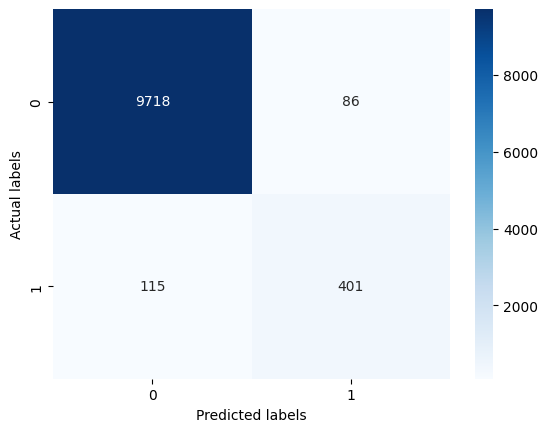

In [ ]:
actual_labels = submission13['Kemiripan']  # Replace 'actual_column_name' with your actual column name
predicted_labels = submission13['predict']

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual_labels, predicted_labels)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [ ]:
# Tampilkan hanya kolom 'Nama' dan 'Usia'
selected_columns = submission12[['Perkara', 'Pasal', 'Kasus', 'Pasal_Pasangan', 'Isi', 'Kemiripan', 'predict']]
selected_rows = selected_columns.iloc[82:85]
selected_rows

,Perkara,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,predict
82,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,362.0,"Barang siapa mengambil barang sesuatu, yang se...",0.0,0.0
83,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,372.0,Barang siapa dengan sengaja dan melawan hukum ...,1.0,1.0
84,Penggelapan,372.0,PERTAMA : --------- Bahwa ia terdakwa Her...,303.0,(1) Diancam dengan pidana penjara paling lama ...,0.0,0.0


In [ ]:
# Tampilkan hanya kolom 'Nama' dan 'Usia'
selected_columns = submission12[['Perkara', 'Pasal', 'Kasus', 'Pasal_Pasangan', 'Isi', 'Kemiripan', 'predict']]
selected_rows = selected_columns.iloc[188:190]
selected_rows

,Perkara,Pasal,Kasus,Pasal_Pasangan,Isi,Kemiripan,predict
188,Penganiayaan,351.0,"Bahwa ia Terdakwa AGUNG SETIAWAN Bin MAKMUR, p...",351.0,(1) Penganiayaan diancam dengan pidana penjara...,1.0,1.0
189,Penganiayaan,351.0,"Bahwa ia Terdakwa AGUNG SETIAWAN Bin MAKMUR, p...",365.0,(1) Diancam dengan pidana penjara paling lama ...,0.0,0.0


## DropOut 0.7

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 258
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(embedded_sequences_q1)
x1 = Dropout(0.7)(x1)
x2 = lstm_layer(embedded_sequences_q2)
x2 = Dropout(0.7)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model14 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model14.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model14.summary()
utils.plot_model(model14, show_shapes=True, expand_nested=True)
cp14=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_07.hdf5',monitor='val_accuracy',verbose=1,save_best_only=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 30, 100)              1699400   ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 bidirectional_3 (Bidirecti  (None, 516)                  740976    ['embedding_3[0][0]',   

In [ ]:
history_w2v_bilstm = model14.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp14]
)

Epoch 1/20
2574/2578 [============================>.] - ETA: 0s - loss: 0.3212 - accuracy: 0.9499 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 35s 11ms/step - loss: 0.3210 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2115 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
  11/2578 [..............................] - ETA: 26s - loss: 0.2626 - accuracy: 0.9290 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2575/2578 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 28s 11ms/step - loss: 0.2020 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2445 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
2573/2578 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9499 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_bilstm_w2v_ner_train_20ep_07.hdf5
2578/2578 [==============================] - 28s 11ms/step - loss: 0.1979 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2444 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/20
2573/2578 [===========

In [ ]:
y_pred_test = model14.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission14 = test.copy()
submission14['Kemiripan'] = submission14['Kemiripan'].astype('float32')
submission14['predict'] = y_pred_test
submission14['predict'] = submission14['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission14.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_07.csv',index=False)

323/323 [==============================] - 3s 4ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+BiLSTM 20 Epoch 0.7')
print('---------------------------')
print(classification_report(submission14['Kemiripan'],submission14['predict']))
print('---------------------------')

Model Metrics for Word2Vec+BiLSTM 20 Epoch 0.7
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission14['Accuracy'] = (submission14['Kemiripan'] == submission14['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission14['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission14 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_bilstm_07.csv')
submission14 = submission14.astype(str)

# CNN

## Kernel 2

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 2
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model21 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model21.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model21.summary()
utils.plot_model(model21, show_shapes=True, expand_nested=True)
cp21=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_2.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 30, 100)              1699400   ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 conv1d (Conv1D)             (None, 29, 258)              51858     ['embedding_4[0][0]',   

In [ ]:
history_w2v_cnn = model21.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp21]
)

Epoch 1/20
2576/2578 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.9427 - precision_4: 0.4080 - recall_4: 0.3230
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 17s 4ms/step - loss: 0.3834 - accuracy: 0.9427 - precision_4: 0.4080 - recall_4: 0.3227 - val_loss: 0.2151 - val_accuracy: 0.9500 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/20
  28/2578 [..............................] - ETA: 9s - loss: 0.2224 - accuracy: 0.9464 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2575/2578 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9557 - precision_4: 0.9034 - recall_4: 0.1271
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1652 - accuracy: 0.9557 - precision_4: 0.9034 - recall_4: 0.1271 - val_loss: 0.1267 - val_accuracy: 0.9684 - val_precision_4: 0.8493 - val_recall_4: 0.4485
Epoch 3/20
2575/2578 [============================>.] - ETA: 0s - loss: 0.1118 - accuracy: 0.9700 - precision_4: 0.8595 - recall_4: 0.4767
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_2.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1118 - accuracy: 0.9700 - precision_4: 0.8597 - recall_4: 0.4770 - val_loss: 0.0983 - val_accuracy: 0.9740 - val_precision_4: 0.8384 - val_recall_4: 0.5942
Epoch 4/20
2578/2578 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 

In [ ]:
y_pred_test = model21.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission21 = test.copy()
submission21['Kemiripan'] = submission21['Kemiripan'].astype('float32')
submission21['predict'] = y_pred_test
submission21['predict'] = submission21['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission21.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_2.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN+ner 20 Epoch 2')
print('---------------------------')
print(classification_report(submission21['Kemiripan'],submission21['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN+ner 20 Epoch 2
---------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      9804
         1.0       0.84      0.67      0.74       516

    accuracy                           0.98     10320
   macro avg       0.91      0.83      0.87     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission21['Accuracy'] = (submission21['Kemiripan'] == submission21['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission21['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9770348837209303


In [ ]:
submission21 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_2.csv')
submission21 = submission21.astype(str)

## Kernel 3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 3
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model22 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model22.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model22.summary()
utils.plot_model(model22, show_shapes=True, expand_nested=True)
cp22=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_3.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 30, 100)              1699400   ['input_11[0][0]',            
                                                                     'input_12[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 258)              77658     ['embedding_5[0][0]',   

In [ ]:
history_w2v_cnn = model22.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp22]
)

Epoch 1/20
2573/2578 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 12s 4ms/step - loss: 0.2748 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1810 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/20
  28/2578 [..............................] - ETA: 9s - loss: 0.1660 - accuracy: 0.9576 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2572/2578 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1615 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1483 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 3/20
2569/2578 [============================>.] - ETA: 0s - loss: 0.1366 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_3.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1366 - accuracy: 0.9500 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 0.1271 - val_accuracy: 0.9500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/20
2569/2578 [=====================

In [ ]:
y_pred_test = model22.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission22 = test.copy()
submission22['Kemiripan'] = submission22['Kemiripan'].astype('float32')
submission22['predict'] = y_pred_test
submission22['predict'] = submission22['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission22.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_3.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN+ner 20 Epoch 3')
print('---------------------------')
print(classification_report(submission22['Kemiripan'],submission22['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN+ner 20 Epoch 3
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.77      0.72      0.74       516

    accuracy                           0.98     10320
   macro avg       0.88      0.85      0.87     10320
weighted avg       0.97      0.98      0.97     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission22['Accuracy'] = (submission22['Kemiripan'] == submission22['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission22['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9752906976744186


In [ ]:
submission22 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_3.csv')
submission22 = submission22.astype(str)

## Kernel 4

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 4
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model23 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model23.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model23.summary()
utils.plot_model(model23, show_shapes=True, expand_nested=True)
cp23=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_4.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 30, 100)              1699400   ['input_13[0][0]',            
                                                                     'input_14[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 27, 258)              103458    ['embedding_6[0][0]',   

In [ ]:
history_w2v_cnn = model23.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp23]
)

Epoch 1/20
2573/2578 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9499 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 12s 4ms/step - loss: 0.1847 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.1465 - val_accuracy: 0.9500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/20
  28/2578 [..............................] - ETA: 9s - loss: 0.1195 - accuracy: 0.9621 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2567/2578 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1333 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.1218 - val_accuracy: 0.9500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 3/20
2574/2578 [============================>.] - ETA: 0s - loss: 0.1106 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_4.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1105 - accuracy: 0.9500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_loss: 0.1031 - val_accuracy: 0.9500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/20
2569/2578 [=====================

In [ ]:
y_pred_test = model23.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission23 = test.copy()
submission23['Kemiripan'] = submission23['Kemiripan'].astype('float32')
submission23['predict'] = y_pred_test
submission23['predict'] = submission23['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission23.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_4.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN+ner 20 Epoch 4')
print('---------------------------')
print(classification_report(submission23['Kemiripan'],submission23['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN+ner 20 Epoch 4
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.79      0.73      0.76       516

    accuracy                           0.98     10320
   macro avg       0.89      0.86      0.88     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission23['Accuracy'] = (submission23['Kemiripan'] == submission23['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission23['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9772286821705426


In [ ]:
submission23 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_4.csv')
submission23 = submission23.astype(str)

## Kernel 5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 258
kernel_size = 5
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Apply Global Max Pooling to reduce the dimensionality
x1 = GlobalMaxPooling1D()(x1)
x2 = GlobalMaxPooling1D()(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model24 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model24.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model24.summary()
utils.plot_model(model24, show_shapes=True, expand_nested=True)
cp24=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_5.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 30)]                 0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 30, 100)              1699400   ['input_15[0][0]',            
                                                                     'input_16[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 26, 258)              129258    ['embedding_7[0][0]',   

In [ ]:
history_w2v_cnn = model24.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp24]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 12s 4ms/step - loss: 0.1772 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.1411 - val_accuracy: 0.9500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/20
  28/2578 [..............................] - ETA: 9s - loss: 0.1464 - accuracy: 0.9475 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2574/2578 [============================>.] - ETA: 0s - loss: 0.1280 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1280 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.1175 - val_accuracy: 0.9500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 3/20
2573/2578 [============================>.] - ETA: 0s - loss: 0.1060 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn_w2v_ner_train_20ep_5.hdf5
2578/2578 [==============================] - 11s 4ms/step - loss: 0.1060 - accuracy: 0.9500 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 0.0975 - val_accuracy: 0.9500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 4/20
2570/2578 [=====================

In [ ]:
y_pred_test = model24.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission24 = test.copy()
submission24['Kemiripan'] = submission24['Kemiripan'].astype('float32')
submission24['predict'] = y_pred_test
submission24['predict'] = submission24['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission24.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_5.csv',index=False)

323/323 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN+ner 20 Epoch 5')
print('---------------------------')
print(classification_report(submission24['Kemiripan'],submission24['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN+ner 20 Epoch 5
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.79      0.72      0.75       516

    accuracy                           0.98     10320
   macro avg       0.89      0.86      0.87     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission24['Accuracy'] = (submission24['Kemiripan'] == submission24['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission24['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9763565891472868


In [ ]:
submission24 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnn_5.csv')
submission24 = submission24.astype(str)

# CNN-BiLSTM

## Kernel 2 DropOut 0.2

In [ ]:
from tensorflow.keras.layers import concatenate

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 128
kernel_size = 2
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 128
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.2)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.2)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model31 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model31.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model31.summary()
utils.plot_model(model31, show_shapes=True, expand_nested=True)
cp31=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_2_02.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              1699400   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 29, 128)              25728     ['embedding[0][0]',       

In [ ]:
history_w2v_cnnbilstm = model31.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp31]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9500 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_2_02.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 386s 147ms/step - loss: 0.2512 - accuracy: 0.9500 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1636 - val_accuracy: 0.9500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.9507 - precision: 0.9375 - recall: 0.0145
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_2_02.hdf5
2578/2578 [==============================] - 377s 146ms/step - loss: 0.1436 - accuracy: 0.9507 - precision: 0.9375 - recall: 0.0145 - val_loss: 0.1030 - val_accuracy: 0.9645 - val_precision: 0.8984 - val_recall: 0.3262
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9665 - precision: 0.9187 - recall: 0.3618
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_2_02.hdf5
2578/2578 [==============================] - 378s 146ms/step -

In [ ]:
y_pred_test = model31.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission31 = test.copy()
submission31['Kemiripan'] = submission31['Kemiripan'].astype('float32')
submission31['predict'] = y_pred_test
submission31['predict'] = submission31['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission31.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_2_02.csv',index=False)

323/323 [==============================] - 13s 36ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 2 0.2')
print('---------------------------')
print(classification_report(submission31['Kemiripan'],submission31['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 2 0.2
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.79      0.80      0.79       516

    accuracy                           0.98     10320
   macro avg       0.89      0.89      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission31['Accuracy'] = (submission31['Kemiripan'] == submission31['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission31['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.9790697674418605


In [ ]:
submission31 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_2_02.csv')
submission31 = submission31.astype(str)

## Kernel 3 DropOut 0.3

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 128
kernel_size = 3
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 128
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.3)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.3)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model32 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model32.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model32.summary()
utils.plot_model(model32, show_shapes=True, expand_nested=True)
cp32=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_3_03.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              1699400   ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 28, 128)              38528     ['embedding_1[0][0]',   

In [ ]:
history_w2v_cnnbilstm = model32.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp32]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9477 - precision_1: 0.0756 - recall_1: 0.0041
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_3_03.hdf5
2578/2578 [==============================] - 365s 139ms/step - loss: 0.2636 - accuracy: 0.9477 - precision_1: 0.0756 - recall_1: 0.0041 - val_loss: 0.1750 - val_accuracy: 0.9500 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9506 - precision_1: 0.9077 - recall_1: 0.0143
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_3_03.hdf5
2578/2578 [==============================] - 360s 139ms/step - loss: 0.1537 - accuracy: 0.9506 - precision_1: 0.9077 - recall_1: 0.0143 - val_loss: 0.1024 - val_accuracy: 0.9643 - val_precision_1: 0.7838 - val_recall_1: 0.3942
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9621 - precision_1: 0.9260 - recall_1: 0.2638
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_3_03.hdf5
2578/2578 [==============================] - 345s 134ms/step - loss: 0.1015 - accuracy: 0.9621 - precision_1: 0.9260 - recall_1: 0.2638 - val_loss: 0.0724 - val_accuracy: 0.9775 - val_precision_1: 0.8377 - val_recall_1: 0.6816
Epoch 4/20
2578/2578 [==============================] - ETA: 0s -

In [ ]:
y_pred_test = model32.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission32 = test.copy()
submission32['Kemiripan'] = submission32['Kemiripan'].astype('float32')
submission32['predict'] = y_pred_test
submission32['predict'] = submission32['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission32.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_3_03.csv',index=False)

323/323 [==============================] - 13s 35ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 3 0.3')
print('---------------------------')
print(classification_report(submission32['Kemiripan'],submission32['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 3 0.3
---------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9804
         1.0       0.77      0.82      0.80       516

    accuracy                           0.98     10320
   macro avg       0.88      0.90      0.89     10320
weighted avg       0.98      0.98      0.98     10320

---------------------------


In [ ]:
# Assign values to Accuracy column based on conditions
submission32['Accuracy'] = (submission32['Kemiripan'] == submission32['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission32['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.978875968992248


In [ ]:
submission32 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_3_03.csv')
submission32 = submission32.astype(str)

## Kernel 4 DropOut 0.5

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 128
kernel_size = 4
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 128
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.5)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.5)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model33 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model33.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model33.summary()
utils.plot_model(model33, show_shapes=True, expand_nested=True)
cp33=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_4_05.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 30, 100)              1699400   ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 27, 128)              51328     ['embedding_2[0][0]',   

In [ ]:
history_w2v_cnnbilstm = model33.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp33]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.3316 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_4_05.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 363s 139ms/step - loss: 0.3316 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.1985 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_4_05.hdf5
2578/2578 [==============================] - 340s 132ms/step - loss: 0.2016 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.2135 - val_accuracy: 0.9500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9500 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_4_05.hdf5
2578/2

In [ ]:
y_pred_test = model33.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission33 = test.copy()
submission33['Kemiripan'] = submission33['Kemiripan'].astype('float32')
submission33['predict'] = y_pred_test
submission33['predict'] = submission33['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission33.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_4_05.csv',index=False)

323/323 [==============================] - 13s 35ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 4 0.5')
print('---------------------------')
print(classification_report(submission33['Kemiripan'],submission33['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 4 0.5
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission33['Accuracy'] = (submission33['Kemiripan'] == submission33['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission33['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission33 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_4_05.csv')
submission33 = submission33.astype(str)

## Kernel 5 DropOut 0.7

In [ ]:
# Define input shapes
input_q1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_q2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Define the embedding layer (using pre-trained Word2Vec embeddings)
embedding_layer = Embedding(input_dim=nb_words,
                            output_dim=EMBEDDING_DIM,
                            weights=[embeddings],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Apply the embedding layer to the input sequences
embedded_sequences_q1 = embedding_layer(input_q1)
embedded_sequences_q2 = embedding_layer(input_q2)

# Define Convolutional layers
num_filters = 128
kernel_size = 5
conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')

# Apply Convolutional layers to the embedded sequences
x1 = conv_layer(embedded_sequences_q1)
x2 = conv_layer(embedded_sequences_q2)

# Define the LSTM layers (you can experiment with the number of units)
lstm_units = 128
lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=False))

# Apply LSTM layers to the embedded sequences
x1 = lstm_layer(x1)
x1 = Dropout(0.7)(x1)
x2 = lstm_layer(x2)
x2 = Dropout(0.7)(x2)

cosine_similarity = Lambda(cosine_distance)([x1, x2])

# Add a dense layer for similarity scoring
#dense_layer = Dense(64, activation='relu')(cosine_similarity)

# Add an output layer with a single unit and sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(cosine_similarity)

# Define the Siamese model
model34 = Model(inputs=[input_q1, input_q2], outputs=output)

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model34.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', Precision(), Recall()])

# Display model summary
model34.summary()
utils.plot_model(model34, show_shapes=True, expand_nested=True)
cp34=ModelCheckpoint('/content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_5_07.hdf5',monitor='val_acc',verbose=1,save_best_only=False)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 30, 100)              1699400   ['input_7[0][0]',             
                                                                     'input_8[0][0]']             
                                                                                                  
 conv1d_3 (Conv1D)           (None, 26, 128)              64128     ['embedding_3[0][0]',   

In [ ]:
history_w2v_cnnbilstm = model34.fit(
    [X_q1, X_q2], y_train,
    validation_data=([X_val_q1, X_val_q2], y_val),
    batch_size=32,
    epochs=20,
    callbacks=[cp34]
)

Epoch 1/20
2578/2578 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 1: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_5_07.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2578/2578 [==============================] - 356s 136ms/step - loss: 0.3189 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2111 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
2578/2578 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 2: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_5_07.hdf5
2578/2578 [==============================] - 334s 130ms/step - loss: 0.2023 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.2426 - val_accuracy: 0.9500 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
2578/2578 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9500 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Epoch 3: saving model to /content/gdrive/MyDrive/Tesis/0.001/model_cnn-bilstm_w2v_ner_train_20ep_5_07.hdf5
2578/2

In [ ]:
y_pred_test = model34.predict([X_test_q1,X_test_q2])
threshold = 0.5
submission34 = test.copy()
submission34['Kemiripan'] = submission34['Kemiripan'].astype('float32')
submission34['predict'] = y_pred_test
submission34['predict'] = submission34['predict'].map(lambda x: 1.0 if x > threshold else 0.0)
submission34.to_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_5_07.csv',index=False)

323/323 [==============================] - 13s 36ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report
print('Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 5 0.7')
print('---------------------------')
print(classification_report(submission34['Kemiripan'],submission34['predict']))
print('---------------------------')

Model Metrics for Word2Vec+CNN-BiLSTM+ner 20 Epoch 5 0.7
---------------------------
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      9804
         1.0       0.00      0.00      0.00       516

    accuracy                           0.95     10320
   macro avg       0.47      0.50      0.49     10320
weighted avg       0.90      0.95      0.93     10320

---------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assign values to Accuracy column based on conditions
submission34['Accuracy'] = (submission34['Kemiripan'] == submission34['predict']).astype(int)

# Calculate overall accuracy
overall_accuracy = submission34['Accuracy'].mean()

print("Overall Accuracy:", overall_accuracy)

Overall Accuracy: 0.95


In [ ]:
submission34 = pd.read_csv('/content/gdrive/MyDrive/Tesis/0.001/submission_w2v_ner_cnnbilstm_5_07.csv')
submission34 = submission34.astype(str)